# Clustering on toy data sets


## Introduction
In this exercise, we will perform clustering on two toy data sets. We will use four different clustering algorithms and look at different parameter settings for these algorithms. 

In [1]:
import pandas as pd
import sklearn
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### The datasets

The Spiral (with three arms) and Path-based datasets are downloaded from https://cs.joensuu.fi/sipu/datasets/. On this site are toy/example data sets listed, meant to demonstrate the features and drawbacks of clustering methods.

Load the data sets. The Path-based dataset is called *path* in this notebook, while the Spiral dataset is called *spiral*. 

In [2]:
spiral = pd.read_csv('data/spiral.csv')
path = pd.read_csv('data/pathbased.csv')

In [3]:
spiral.head(2)

,x,y,cluster
0,31.95,7.95,3
1,31.15,7.30,3


In [4]:
spiral.tail(2)

,x,y,cluster
310,15.65,14.5,2
311,15.65,14.6,2


In [5]:
path.head(2)

,x,y,cluster
0,11.25,5.05,1
1,10.95,4.70,1


In [6]:
path.tail(2)

,x,y,cluster
298,15.45,17.8,2
299,15.70,18.4,2


## Inspection
Plot the data sets and study the plots. 
1. How would you expect the clustering on these sets? 
    - I would expect clustering to be fine on these sets. There are clear clusters, however, they are a combination of spherical and non-spherical shapes. Thus, an algorithm is needed that is able to handle both types of shapes. 
2. Where do you expect problems for what clustering algorithms, and why?
    - K-means
        - starts with initializing 2 random centroids. The cluster is determined based on the distance to the nearest centroid. However, it expects spherical shapes. Spiral does not consists of spherical shapes. Path consists of two spherical shapes. KMeans will not be able to classify the clusters accurately. It will like split Path into two clusters and spiral is not doable.
    - Spectral clustering
        - I suspect this algorithm to run quite fine. It can capture complex cluster structures. It has scalability issues, but these datasets are small.
    - Hierarchical agglomerative clustering
        - Good on weird shapes and uneven cluster sizes. I would expect this algorithm to work correctly. Parameter tuning will be important.
    - DBSCAN
        - Works with non-spherical shapes. I also expect this algorithm to work correctly. However, parameter tuning is important.

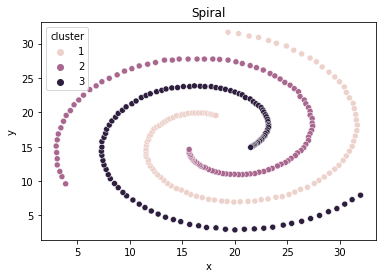

In [7]:
sns.scatterplot(data=spiral, x='x', y='y', hue='cluster')
plt.title('Spiral')
plt.show()

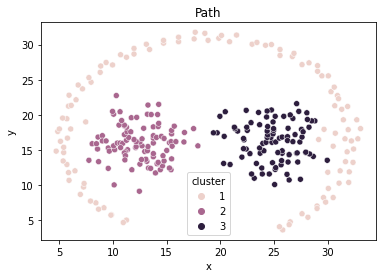

In [8]:
sns.scatterplot(data=path, x='x', y='y', hue='cluster')
plt.title('Path')
plt.show()

## K-means clustering
We first try K-means on the datasets. Perform the following exercises:

1. Inspect the scikit-learn documentation of K-means. What parameters can be set? What are the default values? Why is *n_init* by default 10?
    - Parameters and default value:
        - `n_clusters=8`
        - `init='k-means++'`
        - `n_init=10`
        - `max_iter=300`
        - `tol=0.0001`
        - `verbose=0`
        - `random_state=None`
        - `copy_x=True`
        - `algorithm='lloyd'`
    - Why is the default value of `n_init` `10`? That's because the algorithm is not optimal, it can get stuck in local minima, because of the random initialization of the centroids. The default value of `10` is used to run the algorithm `10` times with different centroid seeds. The best model with the lowest inertia is returned. 
2. Make a function so you can run the K-means algorithm on different datasets with different parameter settings and plot the results easily. The parameters we want to change are *n_clusters* and *n_init*. Use the StandardScaler() on the data before clustering. 
3. Try k-means on the spiral and path datasets and vary with *n_clusters*. How many clusters did you expect in the datasets? Do you get good results?
    - I expected 3 clusters. The behaviour is exactly as expected. When using 3 clusters, it will classify part of cluster 3 as cluster 2. Results are descent, but this algorithm is not the right one for this dataset.
4. Try k-means on the path dataset with *n_clusters = 5*, and set *n_init = 1*. Run this several times. Do you get different results? How do you explain this? 
    - Results are different as the algorithm will get stuck in local minima. The seed is generated randomly.


In [9]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [10]:
def kmeans(X, n_clusters, n_init=10, ax=None):
    pipe = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=n_clusters, n_init=n_init))])
    pipe.fit(X)
    yhat = pipe.predict(X)
    
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=yhat, ax=ax)
    
    plt.title('KMeans')

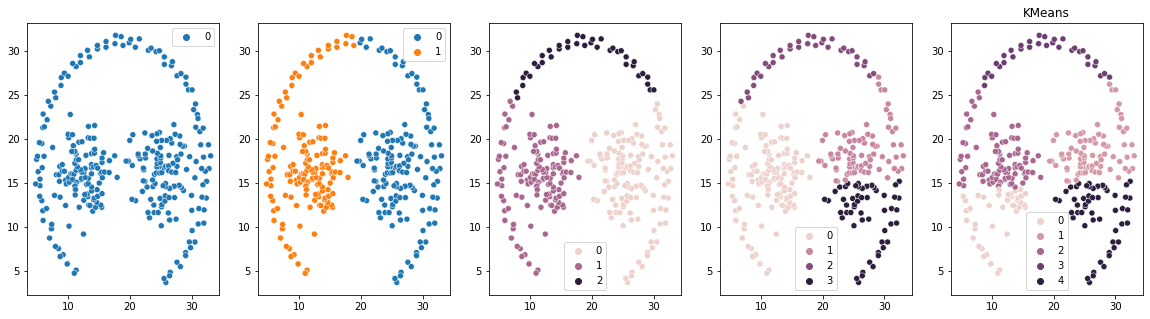

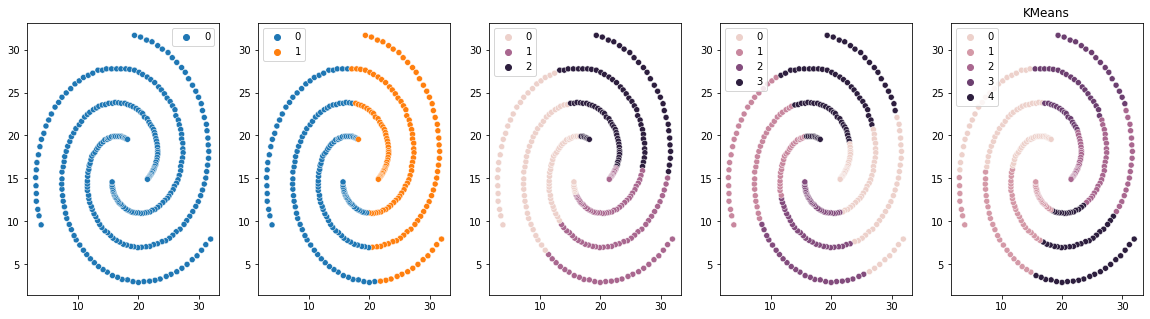

In [11]:
# path
X = path[['x', 'y']].values
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
n_clusters = np.arange(1, 6)
for ax, n in zip(axs.flatten(), n_clusters):
    kmeans(X, n, ax=ax)
    
plt.show()

# spiral
X = spiral[['x', 'y']].values
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
n_clusters = np.arange(1, 6)
for ax, n in zip(axs.flatten(), n_clusters):
    kmeans(X, n, ax=ax)
    
plt.show()

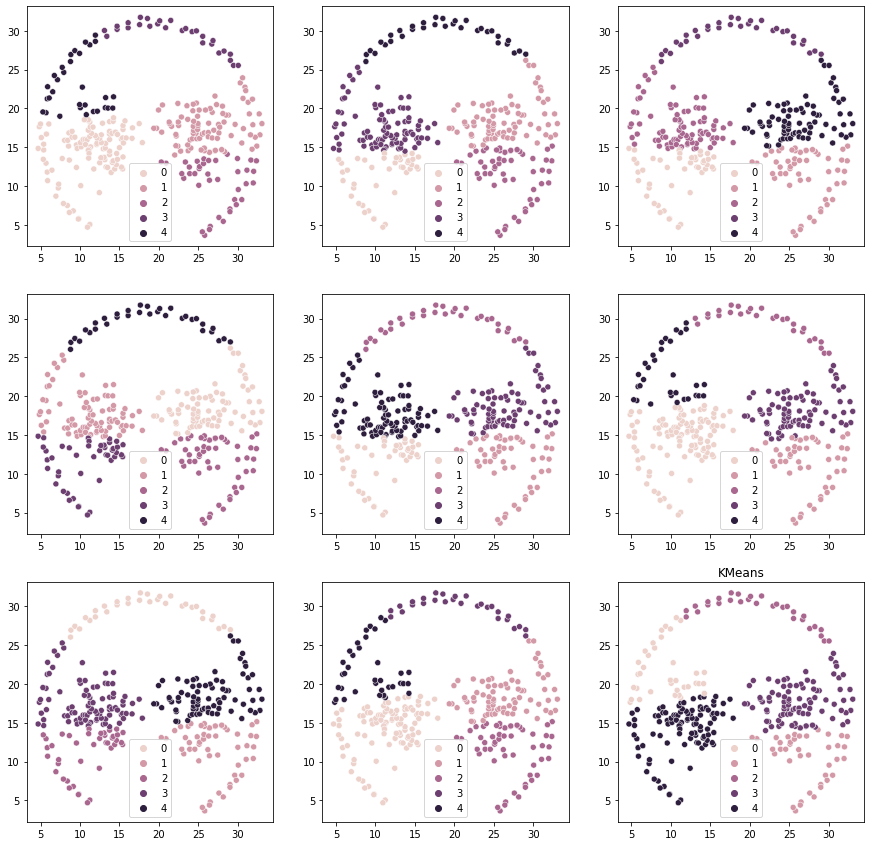

In [12]:
# Running n_init=1 several times
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

X = path[['x', 'y']].values
for ax, i in zip(axs.flatten(), range(1, 10)):
    kmeans(X, 5, n_init=1, ax=ax)

plt.show()

## Spectral clustering
Now we will try spectral clustering on the datasets. Perform the following exercises:

1. Inspect the scikit-learn documentation of Spectral Clustering. What parameters can be set? What are the default values? What does the *affinity* parameter do? Why is there also an *n_init* parameter here? 
    - Parameters with their default value:
        - `n_clusters=8`
        - `eigen_solver=None`
        - `n_components=None`
        - `random_state=None`
        - `n_init=10`
        - `gamma=10`
        - `affinity='rbf'`
        - `n_neighbors=10`
        - `eigen_tol=0.0`
        - `assign_labels='kmeans'`
        - `degree=3`
        - `coef0=1`
        - `kernel_params=None`
        - `n_jobs=None`
        - `verbose=False`
    - `affinity` parameter: determines how to construct the affinity matrix. Spectral clustering requires the adjacency matrix of a graph. The affinity matrix can be used for that. It is used to find graph cuts.
    - `n_init` parameter: necessary if the `assign_labels` parameter is `kmeans`. As said before, `kmeans` is initialized randomly. Therefore you can get stuck in local minima. This can be overcome by running the algorithm several times, and that is determined by `n_init`.
2. Make a function so you can run the algorithm on different datasets with different parameter settings and plot the results easily. The parameters we want to change are *n_clusters* and *affinity*. Parameters that are related to the *affinity*-setting can also vary. Use the StandardScaler() on the data before clustering. 
3. Try Spectral clustering on the spiral and path datasets. Vary with *n_clusters* and *affinity*. Do you get good results?
    - Although the algorithm can follow the shape of the circle partly, it doesn't capture the clusters in a good way. It is not accurate.
4. For the spiral set, try for the options for *affinity* which lead to the best results different parameters. (for example, for *affinity=rbf*, *gamma* can be set). Can you find a good clustering now?
    - Clustering is alright, but it not very accurate.
5. Do the same for the path set. Can you find a good clustering?
    - Clustering is alright, but it not very accurate.

In [13]:
from sklearn.cluster import SpectralClustering
from itertools import product

In [39]:
def spectral_cl(X, n_clusters, affinity, ax=None):
    pipe = Pipeline([('scaler', StandardScaler()), ('spectral_clustering', SpectralClustering(n_clusters=n_clusters, affinity=affinity))])
    yhat = pipe.fit_predict(X)
    
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=yhat, ax=ax)


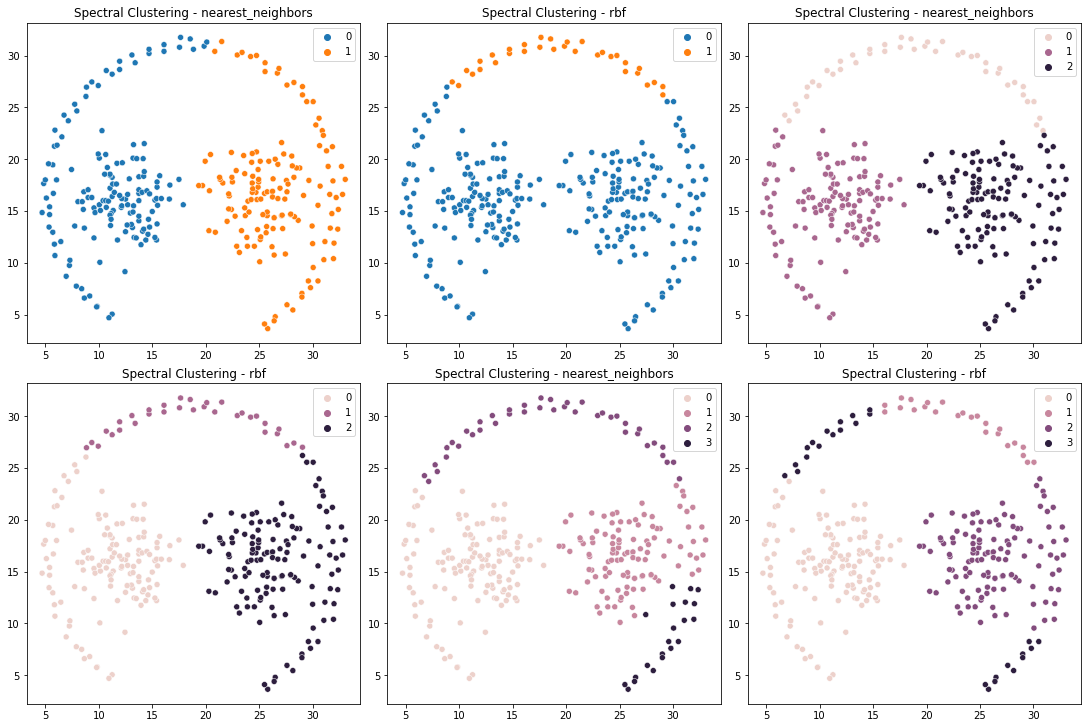

In [16]:
affinities = ['nearest_neighbors', 'rbf']
n_clusters = [2, 3, 4]

params = product(n_clusters, affinities)

# path
fig, axs = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)

X = path[['x', 'y']].values
for ax, param in zip(axs.flatten(), params):
    n, aff = param
    spectral_cl(X, n_clusters=n, affinity=aff, ax=ax)
    ax.set_title(f'Spectral Clustering - {aff}')

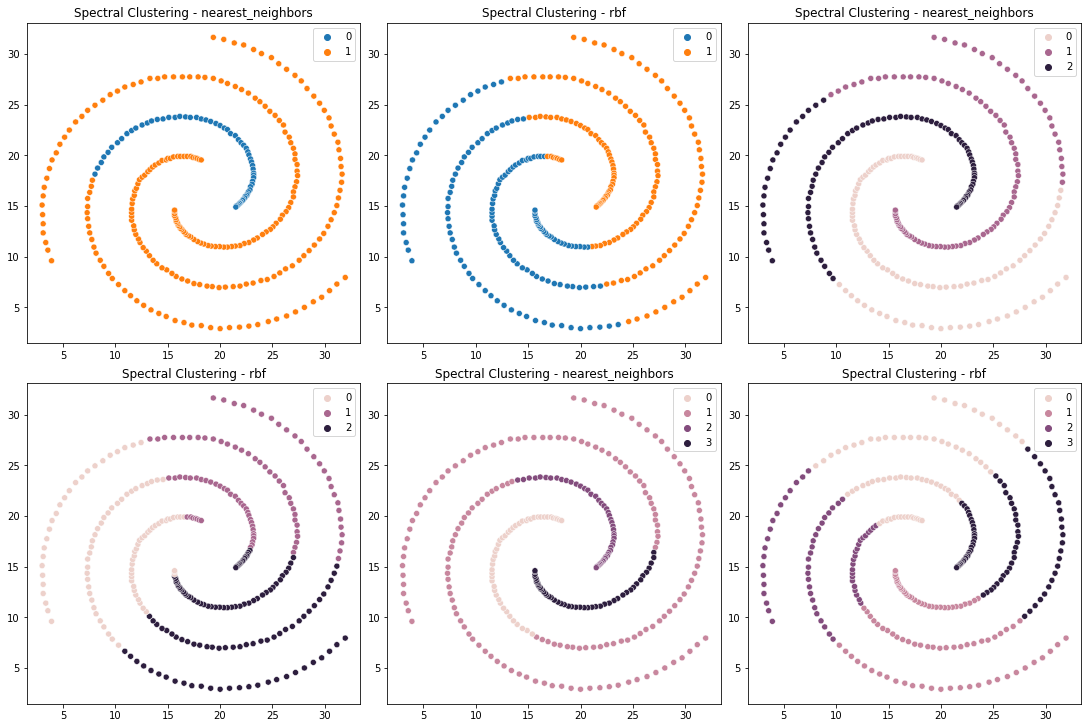

In [32]:
# spiral
params = product(n_clusters, affinities)

fig, axs = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)

X = spiral[['x', 'y']].values
for ax, param in zip(axs.flatten(), params):
    n, aff = param
    spectral_cl(X, n_clusters=n, affinity=aff, ax=ax)
    ax.set_title(f'Spectral Clustering - {aff}')

In [51]:
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import RandomizedSearchCV

def spectral_score(X, y, **kwargs):
    pipe = Pipeline([('scaler', StandardScaler()), ('spectral_clustering', SpectralClustering(**kwargs))])
    yhat = pipe.fit_predict(X)
    
    return adjusted_rand_score(y, yhat)

In [65]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'spectral_clustering', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'spectral_clustering__affinity', 'spectral_clustering__assign_labels', 'spectral_clustering__coef0', 'spectral_clustering__degree', 'spectral_clustering__eigen_solver', 'spectral_clustering__eigen_tol', 'spectral_clustering__gamma', 'spectral_clustering__kernel_params', 'spectral_clustering__n_clusters', 'spectral_clustering__n_components', 'spectral_clustering__n_init', 'spectral_clustering__n_jobs', 'spectral_clustering__n_neighbors', 'spectral_clustering__random_state', 'spectral_clustering__verbose'])

In [79]:
X, y = spiral[['x', 'y']].values, spiral['cluster'].values

pipe = Pipeline([('scaler', StandardScaler()), ('spectral_clustering', SpectralClustering(n_clusters=3))])

params = {
    'spectral_clustering__affinity': ['rbf', 'poly', 'sigmoid', 'laplacian', 'chi2'],
    'spectral_clustering__gamma': np.arange(1, 500, 100)
}


clf = RandomizedSearchCV(pipe, param_distributions=params, random_state=0, scoring='adjusted_rand_score')
search = clf.fit(X, y)

In [80]:
search.best_params_

{'spectral_clustering__gamma': 1, 'spectral_clustering__affinity': 'poly'}

<AxesSubplot:>

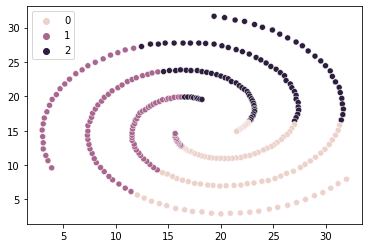

In [81]:
pipe = Pipeline([('scaler', StandardScaler()), ('spectral_clustering', SpectralClustering(n_clusters=3, affinity='poly', gamma=1))])
yhat = pipe.fit_predict(X)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=yhat)

In [82]:
# path
X, y = path[['x', 'y']].values, path['cluster'].values

pipe = Pipeline([('scaler', StandardScaler()), ('spectral_clustering', SpectralClustering(n_clusters=3))])

params = {
    'spectral_clustering__affinity': ['rbf', 'poly', 'sigmoid', 'laplacian', 'chi2'],
    'spectral_clustering__gamma': np.arange(1, 500, 100)
}


clf = RandomizedSearchCV(pipe, param_distributions=params, random_state=0, scoring='adjusted_rand_score')
search = clf.fit(X, y)

In [83]:
search.best_params_

{'spectral_clustering__gamma': 1, 'spectral_clustering__affinity': 'poly'}

<AxesSubplot:>

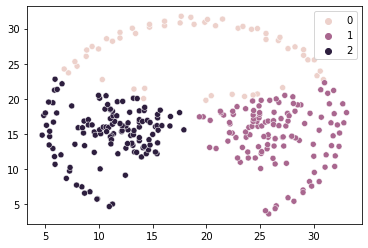

In [84]:
pipe = Pipeline([('scaler', StandardScaler()), ('spectral_clustering', SpectralClustering(n_clusters=3, affinity='poly', gamma=1))])
yhat = pipe.fit_predict(X)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=yhat)

## Hierarchical agglomerative clustering
Now we will try agglomerative clustering on the datasets. Perform the following exercises:

1. Inspect the scikit-learn documentation of Agglomerative Clustering. What parameters can be set? What are the default values? What does the *affinity* parameter do? What does the *connectivity* parameter do?

2. Make a function so you can run the algorithm on different datasets with different parameter settings and plot the results easily. Use the StandardScaler() on the data before clustering. 

3. Try Agglomerative clustering on the spiral and path datasets. Vary with *n_clusters*, *affinity*. Do you get good results?

4. Create a connectivity matrix by using kneighbors_graph(). Use this in the clustering algorithm and vary again with the *affinity* parameter. Do you get good results now?

## DBSCAN
Now we will try DBSCAN on the datasets. Perform the following exercises:

1. Inspect the scikit-learn documentation of DBSCAN. What parameters can be set? What are the default values? 

2. Make a function so you can run the algorithm on different datasets with different parameter settings and plot the results easily. Use the StandardScaler() on the data before clustering. 

3. Try DBSCAN on the spiral and path datasets. Vary with *eps* and *min_samples*. Do you get good results?

## Evaluation
Which method works best for which data set, based on the results above?
